# Benchmarking data sampling techniques for Credit Card Fraud Detection 

## **Introduction** 

This repository is going to show how I have used a HIGHLY unbalanced dataset — the Credit Card Fraud Detection dataset — from Kaggle. The target variables are 0 — for non fraudulent, and 1 — for fraudulent. The positive class 1 (fraudulent) accounts for only 0.17% of the whole dataset. How am I going to sample data for modelling when there is so much imbalance?

In this project, several implemented data sampling algorithms are used in conjunction with a classifier in order to examine the improvement of the classifier’s output quality.

Data sampling algorithms change the composition of the training dataset to improve the performance of a standard machine learning algorithm on an imbalanced classification problem.

There are perhaps three main types of data sampling techniques; we will implement the following methods:

**Data Oversamplinug:**
* Random Oversampling
* SMOTE
* ADASYN

**Data Undersampling:**
* Random Undersampling
* Tomek Links
* Edited Nearest Neighbors

**Combined Oversampling and Undersampling:**
* SMOTE and Random Undersampling
* SMOTE and Tomek Links
* SMOTE and Edited Nearest Neighbors

### Outline:

1. Data preparation and visualization

2. Benchmark over-sampling methods

3. Benchmark under-sampling methods

4. Benchmark over+under methods

### Data preparation and visualization

This dataset is a HIGHLY unbalanced dataset, meaning the target classes are unbalanced Class = 0,1 0 = Non-fraud 1 = Fraud


In [31]:
# Imported Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import interp
from sklearn import metrics
from sklearn.metrics import auc, roc_curve, average_precision_score, f1_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

df  = pd.read_csv('data/creditcard.csv')    
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


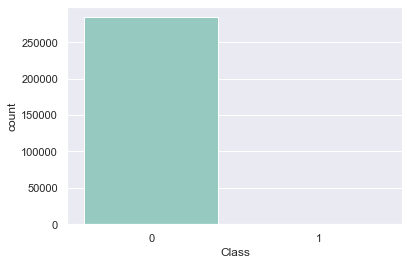

In [17]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='Class', data=df,palette="Set3")

We can see that the data are highly unbalanced, meaning the data in class variable of 0 is very high compared to the class variable of 1



We will first scale the columns comprise of Time and Amount.  So we shall standardise the "Amount" and "Time"  data, since all the other columns have been obtained through PCA.

In [32]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

#Split the data into x and y variables

X = df.drop('Class', axis=1)
y = df['Class']

df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Now, spit the data into train and test data. **Why?** 

For testing purposes, although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. 



In [85]:
SK= StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in SK.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

train_unique_label, train_counts_label = np.unique(ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(ytest, return_counts=True)
print('Label Distributions in ytrain and ytest: \n')
print(train_counts_label/len(ytrain))
print(test_counts_label/len(ytest))


Label Distributions in ytrain and ytest: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


The folds are made by preserving the percentage of samples for each class.


## Benchmark over-sampling methods

Oversampling methods involves duplicating examples of the minority class or synthesizing new examples from the minority class from existing examples.

I will attempt to perform 3 methods of Oversampling to resolve this imbalanced dataset issue:
* Random Oversampling
* SMOTE
* ADASYN

For classification Models we choose logistic regression.


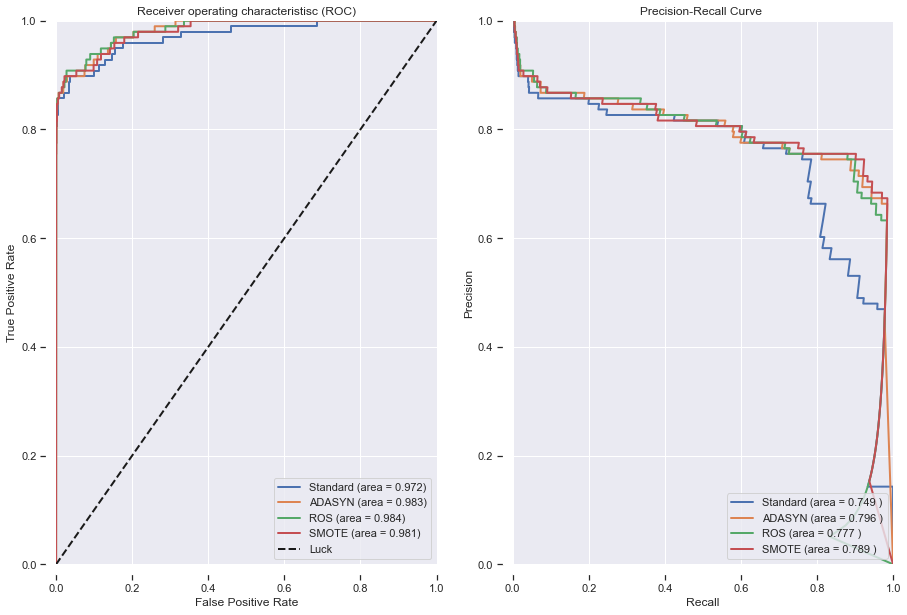

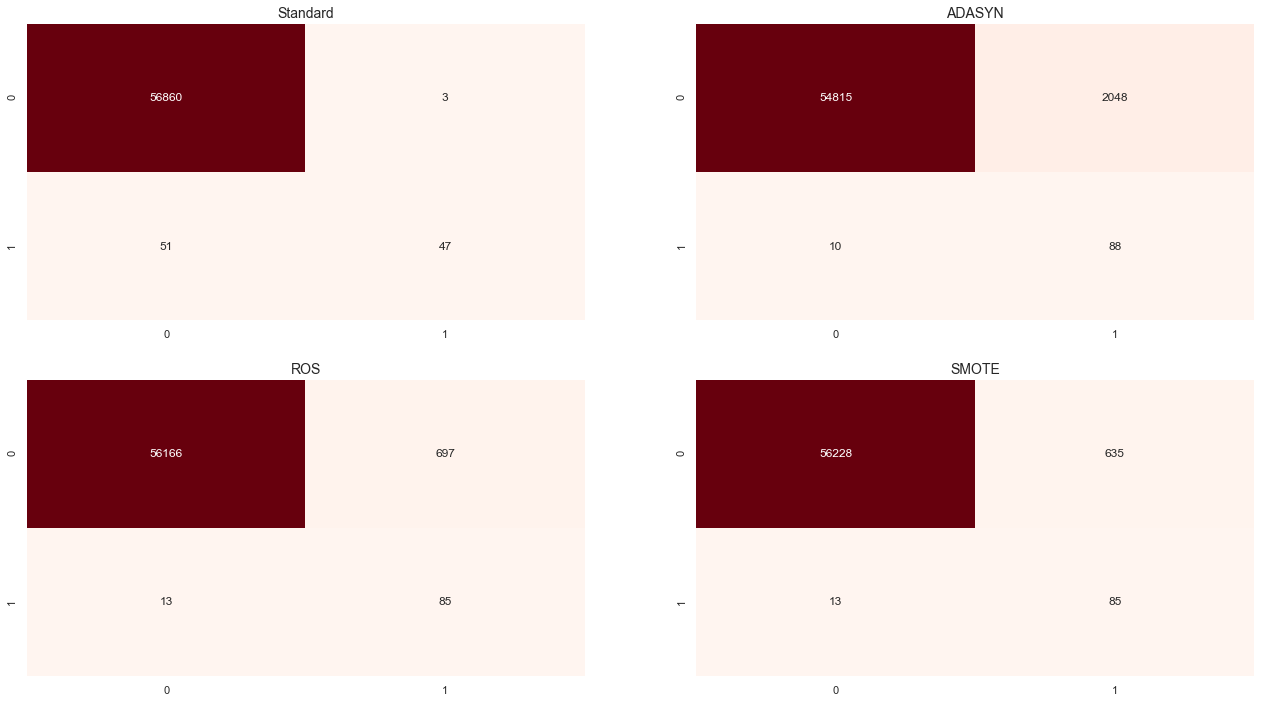

In [92]:
LW = 2
RANDOM_STATE = 42

class DummySampler:
    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        return self.sample(X, y)
    
classifier = [LogisticRegression(solver='liblinear', max_iter=1000)]
samplers = [
    ['Standard', DummySampler()],
    ['ADASYN', ADASYN( )],#random_state=RANDOM_STATE
    ['ROS', RandomOverSampler()],
    ['SMOTE', SMOTE()],]
pipelines = [['{}'.format(sampler[0]),make_pipeline(sampler[1], classifier[0])] for sampler in samplers ]
report_list = pd.DataFrame( index = ['f1', 'precision', 'recall',' average_precision' ],columns =[sampler[0] for sampler in samplers])

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig1, axs1 = plt.subplots(2, 2, figsize=(22,12))
title_cm= [sampler[0] for sampler in samplers]
for (idx, (name, pipeline)), ax1 in zip(enumerate(pipelines,0), axs1.flat):
    yhat= pipeline.fit(Xtrain, ytrain).predict_proba(Xtest)
    ypred = pipeline.fit(Xtrain, ytrain).predict(Xtest)
    fpr, tpr, thresholds = roc_curve(ytest, yhat[:,1])
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(ytest,ypred)
    pr, re, thresholds = precision_recall_curve(ytest, yhat[:,1])
    pr_auc = auc(re, pr)
    report_list.iloc[[0],[idx]] = [f1]
    report_list.iloc[[1],[idx]] = [metrics.precision_score(ytest, ypred)]
    report_list.iloc[[2],[idx]] = [metrics.recall_score(ytest, ypred)]
    report_list.iloc[[3],[idx]] = [average_precision_score(ytest, yhat[:,1])]    
    axs[1].plot(pr, re, linestyle='-', label=r'%s (area = %0.3f )' % (name, pr_auc),lw=LW)
    axs[0].plot(fpr, tpr, label='{} (area = %0.3f)'.format(name) % roc_auc, lw=LW)
# confusion_matrix
    cm_nn = confusion_matrix(ytest,ypred)
    sns.heatmap(cm_nn, ax=ax1,annot=True,robust=True,fmt='g' ,cmap="Reds", cbar=False)
    ax1.set_title(title_cm[idx], fontsize=14)

axs[0].plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')
# make nice plotting
xlabel= ['False Positive Rate', 'Recall']
ylabel= ['True Positive Rate', 'Precision']
title = ['Receiver operating characteristisc (ROC)', 'Precision-Recall Curve ']
for i, ax in  enumerate(axs.flat, 0):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.axis(xmin=0,xmax=1)
    ax.axis(ymin=0,ymax=1)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel(ylabel[i])
    ax.set_title(title[i])
    ax.legend(loc="lower right")

plt.show()


In [45]:
report_list

,Standard,ADASYN,ROS,SMOTE
f1,0.635135,0.0790301,0.200236,0.204327
precision,0.94,0.041334,0.113182,0.115804
recall,0.479592,0.897959,0.867347,0.867347
average_precision,0.74925,0.79141,0.775452,0.783605


**In this case, we can see a modest lift in  Area Under the Precision-Recall Curve (AUPRC) performance from 0.74 with no transforms to about 0.79 with ADASYN and SMOTE. More, we notice an improvement in the detection of fraud.**

## Benchmark under-sampling methods

Undersampling involves deleting examples from the majority class, such as randomly or using an algorithm to carefully choose which examples to delete.

In this section we will implement a 3 methods of undersampling to resolve this imbalanced dataset issue
* Random Undersampling
* Tomek Links
* Edited Nearest Neighbors


In [50]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours 


Standard
[[56860     3]
 [   51    47]]
Under
[[55998   865]
 [   13    85]]
TomekLinks
[[56860     3]
 [   50    48]]
EditedNN
[[56860     3]
 [   46    52]]


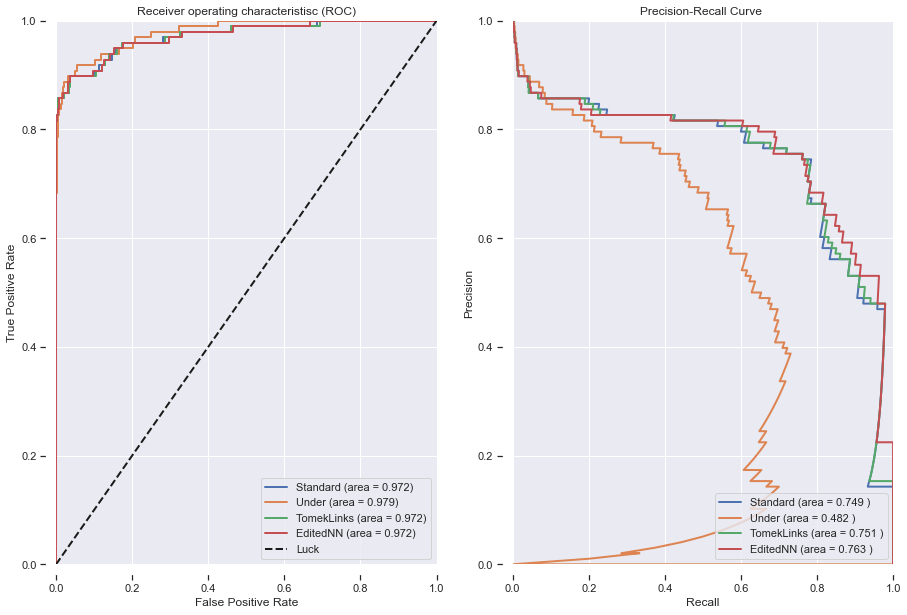

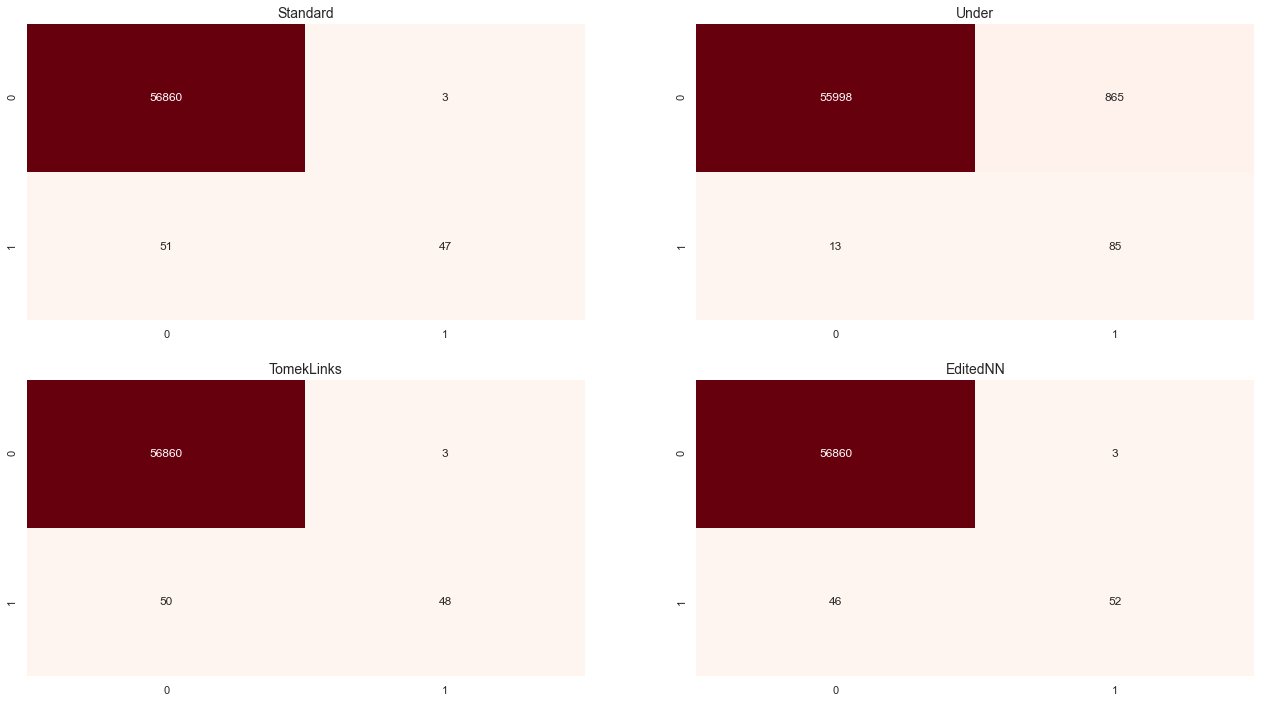

In [84]:
samplers = [
    ['Standard', DummySampler()],
    ['RandomUnder', RandomUnderSampler()],
    ['TomekLinks', TomekLinks()],
    ['EditedNN', EditedNearestNeighbours()],]

pipelines = [['{}'.format(sampler[0]),make_pipeline(sampler[1], classifier[0])] for sampler in samplers ]
report_list = pd.DataFrame( index = ['f1', 'precision', 'recall',' average_precision' ],columns =[sampler[0] for sampler in samplers])

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig1, axs1 = plt.subplots(2, 2, figsize=(22,12))
title_cm= [sampler[0] for sampler in samplers]
for (idx, (name, pipeline)), ax1 in zip(enumerate(pipelines,0), axs1.flat):
    yhat= pipeline.fit(Xtrain, ytrain).predict_proba(Xtest)
    ypred0 = pipeline.fit(Xtrain, ytrain).decision_function(Xtest)
    ypred = pipeline.fit(Xtrain, ytrain).predict(Xtest)
    fpr, tpr, thresholds = roc_curve(ytest, yhat[:,1])
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(ytest,ypred)
    pr, re, thresholds = precision_recall_curve(ytest, yhat[:,1])
    pr_auc = auc(re, pr)
    report_list.iloc[[0],[idx]] = [f1]
    report_list.iloc[[1],[idx]] = [metrics.precision_score(ytest, ypred)]
    report_list.iloc[[2],[idx]] = [metrics.recall_score(ytest, ypred)]
    report_list.iloc[[3],[idx]] = [average_precision_score(ytest, yhat[:,1])]    
    axs[1].plot(pr, re, linestyle='-', label=r'%s (area = %0.3f )' % (name, pr_auc),lw=LW)
    axs[0].plot(fpr, tpr, label='{} (area = %0.3f)'.format(name) % roc_auc, lw=LW)
# confusion_matrix
    cm_nn = confusion_matrix(ytest,ypred)
    sns.heatmap(cm_nn, ax=ax1,annot=True,robust=True,fmt='g' ,cmap="Reds", cbar=False)
    ax1.set_title(title_cm[idx], fontsize=14)
    print(name)
    print(metrics.confusion_matrix(ytest,ypred))

axs[0].plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')
# make nice plotting
xlabel= ['False Positive Rate', 'Recall']
ylabel= ['True Positive Rate', 'Precision']
title = ['Receiver operating characteristisc (ROC)', 'Precision-Recall Curve ']
for i, ax in  enumerate(axs.flat, 0):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.axis(xmin=0,xmax=1)
    ax.axis(ymin=0,ymax=1)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel(ylabel[i])
    ax.set_title(title[i])
    ax.legend(loc="lower right")

plt.show()


In [87]:
report_list

,Standard,Under,TomekLinks,EditedNN
f1,0.635135,0.162214,0.644295,0.679739
precision,0.94,0.0894737,0.941176,0.945455
recall,0.479592,0.867347,0.489796,0.530612
average_precision,0.74925,0.488458,0.751757,0.763181


**We can see that Edited Nearest Neighbors performs MUCH BETTER in predicting the frauds in our dataset with the  Precision-Recall Curve (AUPRC) being 0.8 on the test data. And more, it is the best result in our tests.**


## Benchmark of the combination of over- and under-sampling algorithms

Almost any oversampling method can be combined with almost any undersampling technique. But, in this phase of the project, we will implement examples of popular combinations of over and undersampling.
* SMOTE and Random Undersampling
* SMOTE and Tomek Links
* SMOTE and Edited Nearest Neighbors
* ADASYN and Random Undersampling
* ADASYN and Tomek Links
* ADASYN and Edited Nearest Neighbors



1. **SMOTE + [ Random Undersampling, Tomek Links, Edited Nearest Neighbors]**

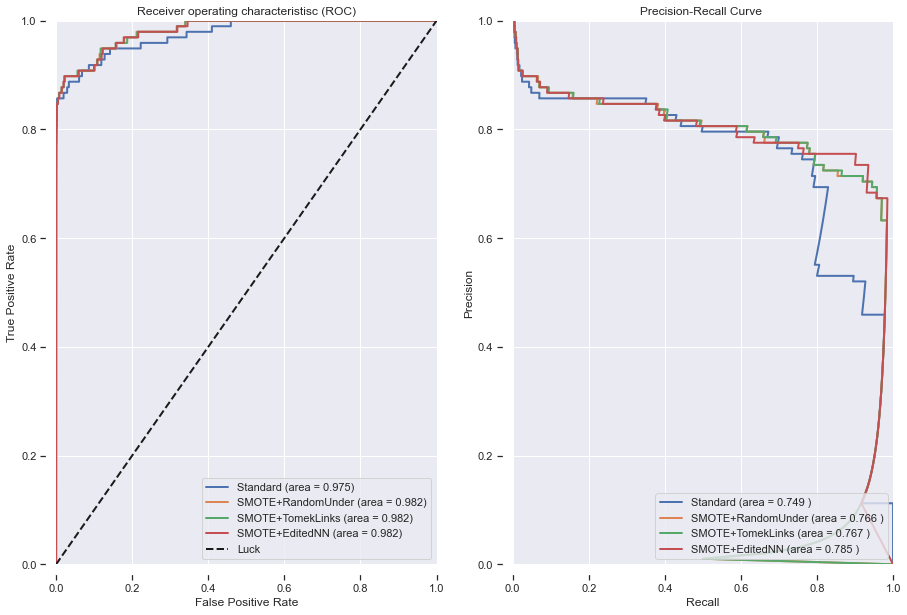

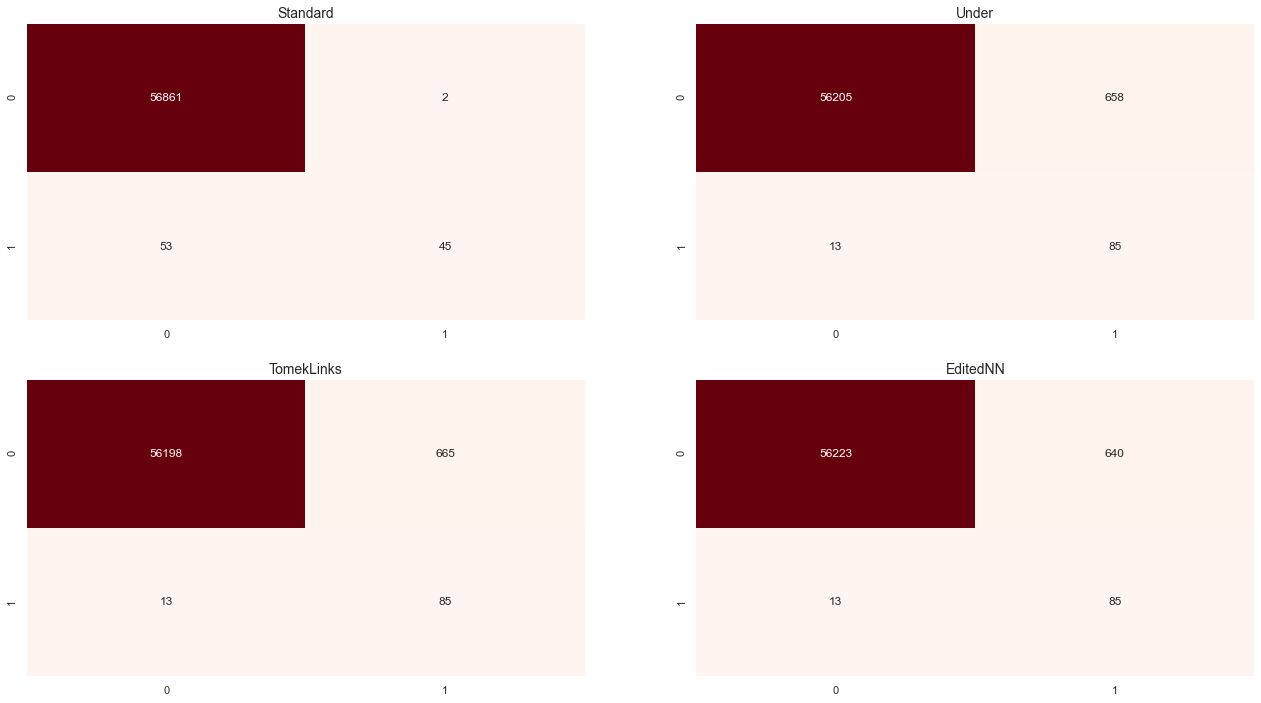

In [88]:
SamplersOverUnder = [
    ['Standard', [DummySampler(),DummySampler()]],
    ['SMOTE+RandomUnder', [SMOTE(), RandomUnderSampler()]],
    ['SMOTE+TomekLinks', [SMOTE(),  TomekLinks()]],
    ['SMOTE+EditedNN', [SMOTE(),  EditedNearestNeighbours()]],]

pipelines = [ ['{}'.format(samplerOvUn[0]), make_pipeline(samplerOvUn[1][0],samplerOvUn[1][1], rand_log_reg )] for samplerOvUn in SamplersOverUnder ]
report_list = pd.DataFrame( index = ['f1', 'precision', 'recall',' average_precision' ],columns =[sampler[0] for sampler in SamplersOverUnder])

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig1, axs1 = plt.subplots(2, 2, figsize=(22,12))
title_cm= [sampler[0] for sampler in SamplersOverUnder]
for (idx, (name, pipeline)), ax1 in zip(enumerate(pipelines,0), axs1.flat):
    yhat= pipeline.fit(Xtrain, ytrain).predict_proba(Xtest)
    ypred = pipeline.fit(Xtrain, ytrain).predict(Xtest)
    fpr, tpr, thresholds = roc_curve(ytest, yhat[:,1])
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(ytest,ypred)
    pr, re, thresholds = precision_recall_curve(ytest, yhat[:,1])
    pr_auc = auc(re, pr)
    report_list.iloc[[0],[idx]] = [f1]
    report_list.iloc[[1],[idx]] = [metrics.precision_score(ytest, ypred)]
    report_list.iloc[[2],[idx]] = [metrics.recall_score(ytest, ypred)]
    report_list.iloc[[3],[idx]] = [average_precision_score(ytest, yhat[:,1])]    
    axs[1].plot(pr, re, linestyle='-', label=r'%s (area = %0.3f )' % (name, pr_auc),lw=LW)
    axs[0].plot(fpr, tpr, label='{} (area = %0.3f)'.format(name) % roc_auc, lw=LW)
# confusion_matrix
    cm_nn = confusion_matrix(ytest,ypred)
    sns.heatmap(cm_nn, ax=ax1,annot=True,robust=True,fmt='g' ,cmap="Reds", cbar=False)
    ax1.set_title(title_cm[idx], fontsize=14)

axs[0].plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')
# make nice plotting
xlabel= ['False Positive Rate', 'Recall']
ylabel= ['True Positive Rate', 'Precision']
title = ['Receiver operating characteristisc (ROC)', 'Precision-Recall Curve ']
for i, ax in  enumerate(axs.flat, 0):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.axis(xmin=0,xmax=1)
    ax.axis(ymin=0,ymax=1)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel(ylabel[i])
    ax.set_title(title[i])
    ax.legend(loc="lower right")

plt.show()


In [89]:
report_list

,Standard,SMOTE+RandomUnder,SMOTE+TomekLinks,SMOTE+EditedNN
f1,0.62069,0.20214,0.200472,0.206561
precision,0.957447,0.114401,0.113333,0.117241
recall,0.459184,0.867347,0.867347,0.867347
average_precision,0.749586,0.766481,0.767,0.781243


2. **ADASYN+[ Random Undersampling, Tomek Links, Edited Nearest Neighbors]**

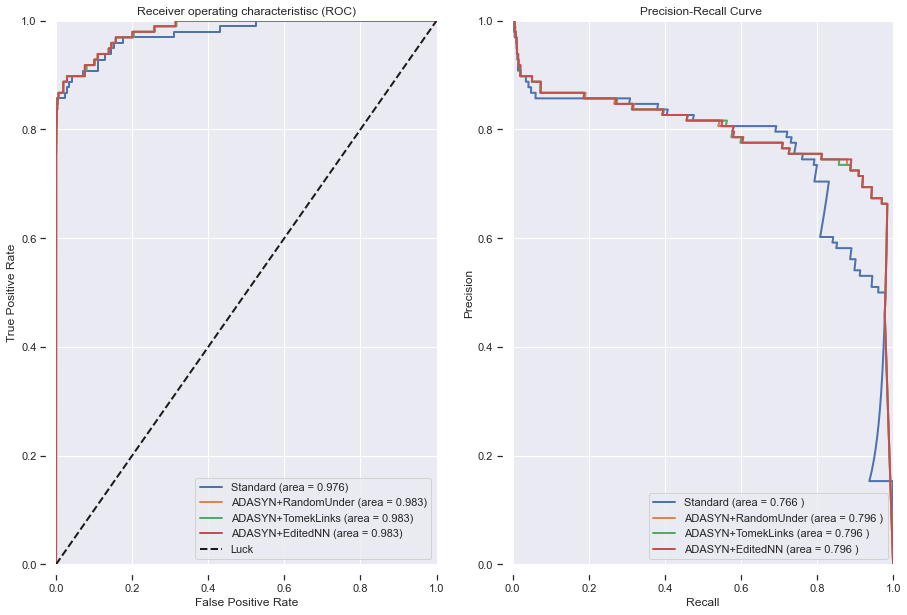

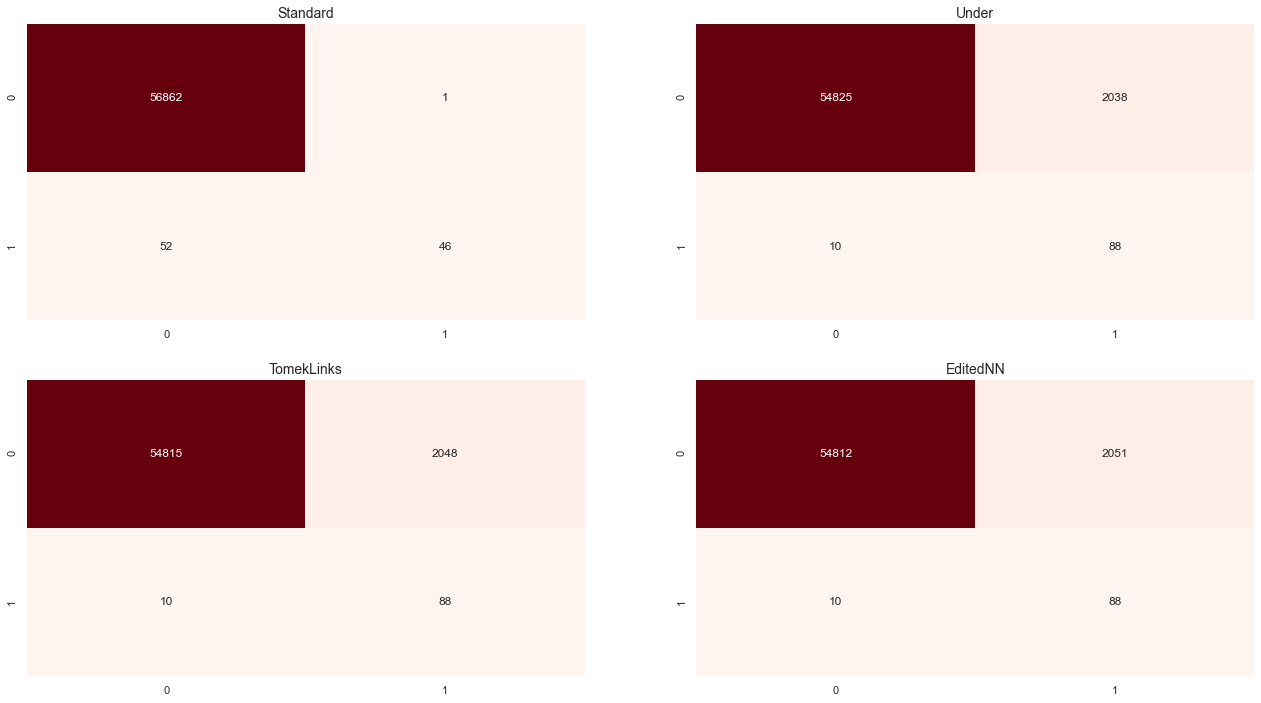

In [90]:
SamplersOverUnder = [
    ['Standard', [DummySampler(),DummySampler()]],
    ['ADASYN+RandomUnder', [ADASYN(), RandomUnderSampler()]],
    ['ADASYN+TomekLinks', [ADASYN(),  TomekLinks()]],
    ['ADASYN+EditedNN', [ADASYN(),  EditedNearestNeighbours()]],]


pipelines = [ ['{}'.format(samplerOvUn[0]), make_pipeline(samplerOvUn[1][0],samplerOvUn[1][1], rand_log_reg )] for samplerOvUn in SamplersOverUnder ]

report_list = pd.DataFrame( index = ['f1', 'precision', 'recall',' average_precision' ],columns =[sampler[0] for sampler in SamplersOverUnder])


fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig1, axs1 = plt.subplots(2, 2, figsize=(22,12))
title_cm= [sampler[0] for sampler in SamplersOverUnder]
for (idx, (name, pipeline)), ax1 in zip(enumerate(pipelines,0), axs1.flat):
#    pipeline.fit(Xtrain, ytrain)
#    best_clf = rand_log_reg.best_estimator_
#    yhat= best_clf.predict_proba(Xtest)
#    ypred0 = best_clf.decision_function(Xtest)
#    ypred = best_clf.predict(Xtest)

    yhat= pipeline.fit(Xtrain, ytrain).predict_proba(Xtest)
#    ypred0 = pipeline.fit(Xtrain, ytrain).decision_function(Xtest)
    ypred = pipeline.fit(Xtrain, ytrain).predict(Xtest)
    fpr, tpr, thresholds = roc_curve(ytest, yhat[:,1])
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(ytest,ypred)
    pr, re, thresholds = precision_recall_curve(ytest, yhat[:,1])
    pr_auc = auc(re, pr)
#    std_auc = np.std(aucs)
    report_list.iloc[[0],[idx]] = [f1]
    report_list.iloc[[1],[idx]] = [metrics.precision_score(ytest, ypred)]
    report_list.iloc[[2],[idx]] = [metrics.recall_score(ytest, ypred)]
    report_list.iloc[[3],[idx]] = [average_precision_score(ytest, yhat[:,1])]    
    axs[1].plot(pr, re, linestyle='-', label=r'%s (area = %0.3f )' % (name, pr_auc),lw=LW)
    axs[0].plot(fpr, tpr, label='{} (area = %0.3f)'.format(name) % roc_auc, lw=LW)
# confusion_matrix
    cm_nn = confusion_matrix(ytest,ypred)
    sns.heatmap(cm_nn, ax=ax1,annot=True,robust=True,fmt='g' ,cmap="Reds", cbar=False)
    ax1.set_title(title_cm[idx], fontsize=14)
#    print(name)
#    print(metrics.confusion_matrix(ytest,ypred))

axs[0].plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')
# make nice plotting
xlabel= ['False Positive Rate', 'Recall']
ylabel= ['True Positive Rate', 'Precision']
title = ['Receiver operating characteristisc (ROC)', 'Precision-Recall Curve ']
for i, ax in  enumerate(axs.flat, 0):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.axis(xmin=0,xmax=1)
    ax.axis(ymin=0,ymax=1)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel(ylabel[i])
    ax.set_title(title[i])
    ax.legend(loc="lower right")

plt.show()


In [91]:
report_list

,Standard,ADASYN+RandomUnder,ADASYN+TomekLinks,ADASYN+EditedNN
f1,0.634483,0.0791367,0.0787825,0.0786768
precision,0.978723,0.0413923,0.0411985,0.0411407
recall,0.469388,0.897959,0.897959,0.897959
average_precision,0.766705,0.791551,0.79143,0.791697
